# Wood Stain Color Classification

This notebook demonstrates how to build classification models for three different wood stain colors:
1. Medium Cherry
2. Desert Oak
3. Graphite Walnut

For each color, we'll build a binary classifier to determine if a sample is "in range" or "out of range".

## Dataset Structure
The dataset is organized as follows:
```
dataset/
├── medium-cherry/
│   ├── out-of-range-too-light/
│   ├── in-range-light/
│   ├── in-range-standard/
│   ├── in-range-dark/
│   └── out-of-range-too-dark/
├── desert-oak/
│   ├── out-of-range-too-light/
│   ├── in-range-light/
│   ├── in-range-standard/
│   ├── in-range-dark/
│   └── out-of-range-too-dark/
└── graphite-walnut/
    ├── out-of-range-too-light/
    ├── in-range-light/
    ├── in-range-standard/
    ├── in-range-dark/
    └── out-of-range-too-dark/
```

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import random
import cv2

# For deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Configuration and Setup

Let's define some parameters for our model and data processing.

In [2]:
# Define configuration parameters
CONFIG = {
    'base_dir': '/Users/rishimanimaran/Documents/College/junior-year/spring-2025/cs-3312/color-validation-app-spring/images-dataset-5.0',  # Update this path to your dataset location
    #'colors': ['medium-cherry', 'desert-oak', 'graphite-walnut'],
    'colors': ['medium-cherry'],
    'in_range_categories': ['in-range-light', 'in-range-standard', 'in-range-dark'],
    'out_of_range_categories': ['out-of-range-too-light', 'out-of-range-too-dark'],
    'img_size': (224, 224),  # Standard input size for many pre-trained models
    'batch_size': 32,
    'epochs': 20,
    'learning_rate': 1e-4,
    'val_split': 0.2,  # 20% validation split
    'test_split': 0.1,  # 10% test split
    'model_type': 'EfficientNetB0',  # Options: 'EfficientNetB0', 'ResNet50V2'
    'color_space': 'RGB',  # Options: 'RGB', 'HSV', 'LAB'
}

## Data Loading and Exploration

First, let's create functions to load and explore our dataset.

In [3]:
def load_dataset_info(base_dir, colors):
    """
    Load dataset information without loading the actual images.
    Returns a DataFrame with image paths and labels.
    """
    data = []
    
    for color in colors:
        color_dir = os.path.join(base_dir, color)
        
        # Check if directory exists
        if not os.path.exists(color_dir):
            print(f"Warning: Directory {color_dir} does not exist. Skipping.")
            continue
            
        # Process all category folders
        for category in os.listdir(color_dir):
            category_dir = os.path.join(color_dir, category)
            
            # Skip if not a directory
            if not os.path.isdir(category_dir):
                continue
                
            # Determine if in range or out of range
            is_in_range = 'in-range' in category
            
            # List all images in this category
            for img_file in os.listdir(category_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(category_dir, img_file)
                    data.append({
                        'color': color,
                        'category': category,
                        'in_range': is_in_range,
                        'img_path': img_path
                    })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    return df

In [4]:
# Load dataset information
dataset_df = load_dataset_info(CONFIG['base_dir'], CONFIG['colors'])

# Display the first few rows
print(f"Total images: {len(dataset_df)}")
dataset_df.head()

Total images: 121


,color,category,in_range,img_path
0,medium-cherry,in-range-light,True,/Users/rishimanimaran/Documents/College/junior...
1,medium-cherry,in-range-light,True,/Users/rishimanimaran/Documents/College/junior...
2,medium-cherry,in-range-light,True,/Users/rishimanimaran/Documents/College/junior...
3,medium-cherry,in-range-light,True,/Users/rishimanimaran/Documents/College/junior...
4,medium-cherry,in-range-light,True,/Users/rishimanimaran/Documents/College/junior...


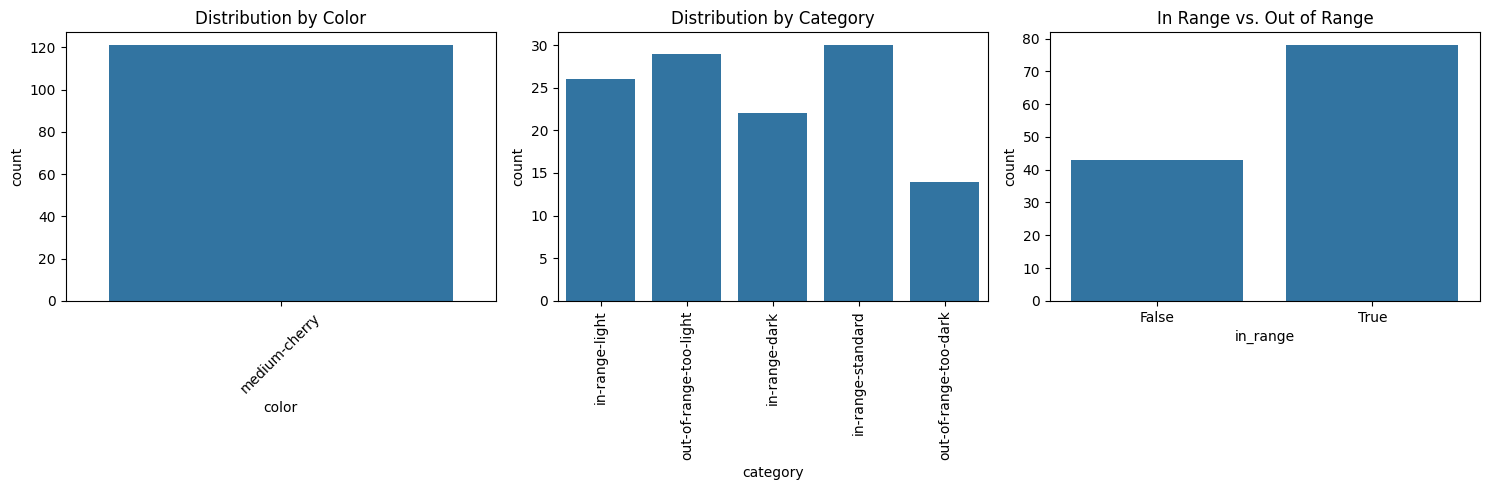

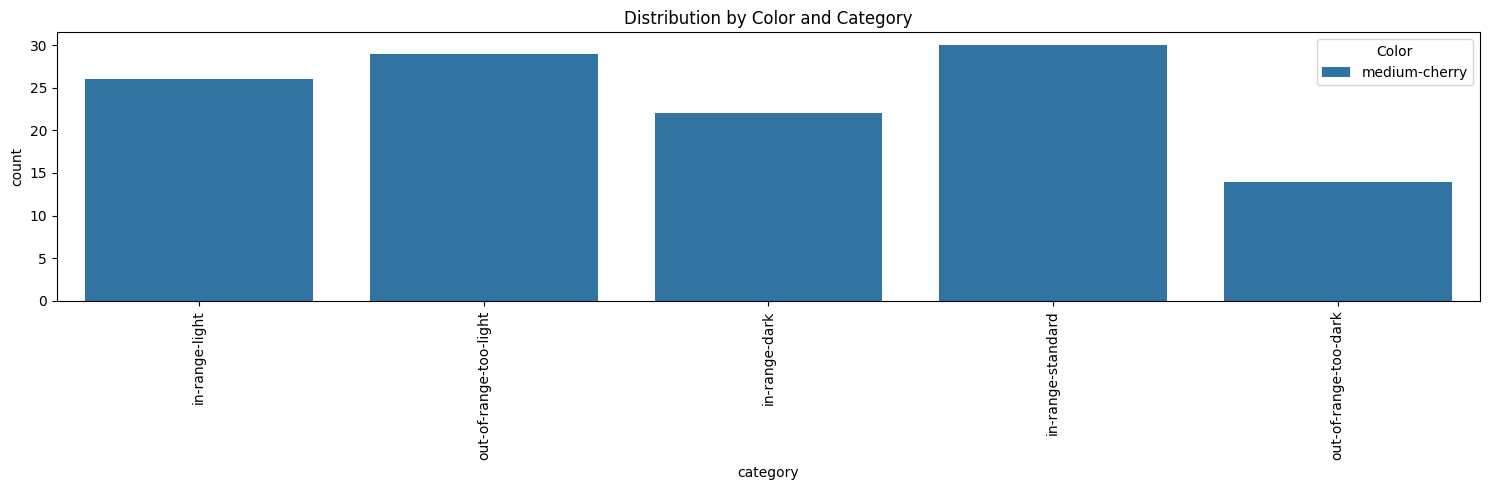

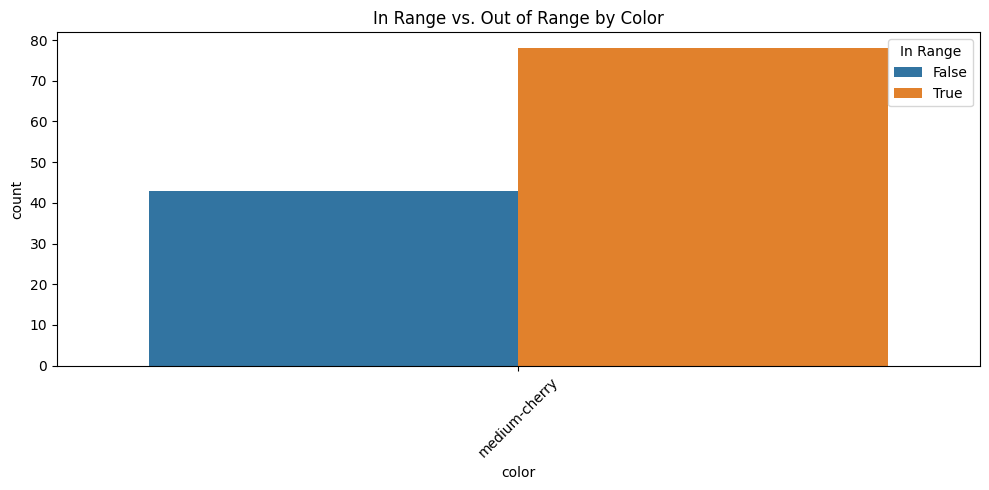

In [5]:
# Analyze dataset distribution
def plot_dataset_distribution(df):
    # Distribution by color
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.countplot(x='color', data=df)
    plt.title('Distribution by Color')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 2)
    sns.countplot(x='category', data=df)
    plt.title('Distribution by Category')
    plt.xticks(rotation=90)
    
    plt.subplot(1, 3, 3)
    sns.countplot(x='in_range', data=df)
    plt.title('In Range vs. Out of Range')
    
    plt.tight_layout()
    plt.show()
    
    # Distribution by color and category
    plt.figure(figsize=(15, 5))
    sns.countplot(x='category', hue='color', data=df)
    plt.title('Distribution by Color and Category')
    plt.xticks(rotation=90)
    plt.legend(title='Color')
    plt.tight_layout()
    plt.show()
    
    # Distribution by color and range
    plt.figure(figsize=(10, 5))
    sns.countplot(x='color', hue='in_range', data=df)
    plt.title('In Range vs. Out of Range by Color')
    plt.xticks(rotation=45)
    plt.legend(title='In Range')
    plt.tight_layout()
    plt.show()

plot_dataset_distribution(dataset_df)

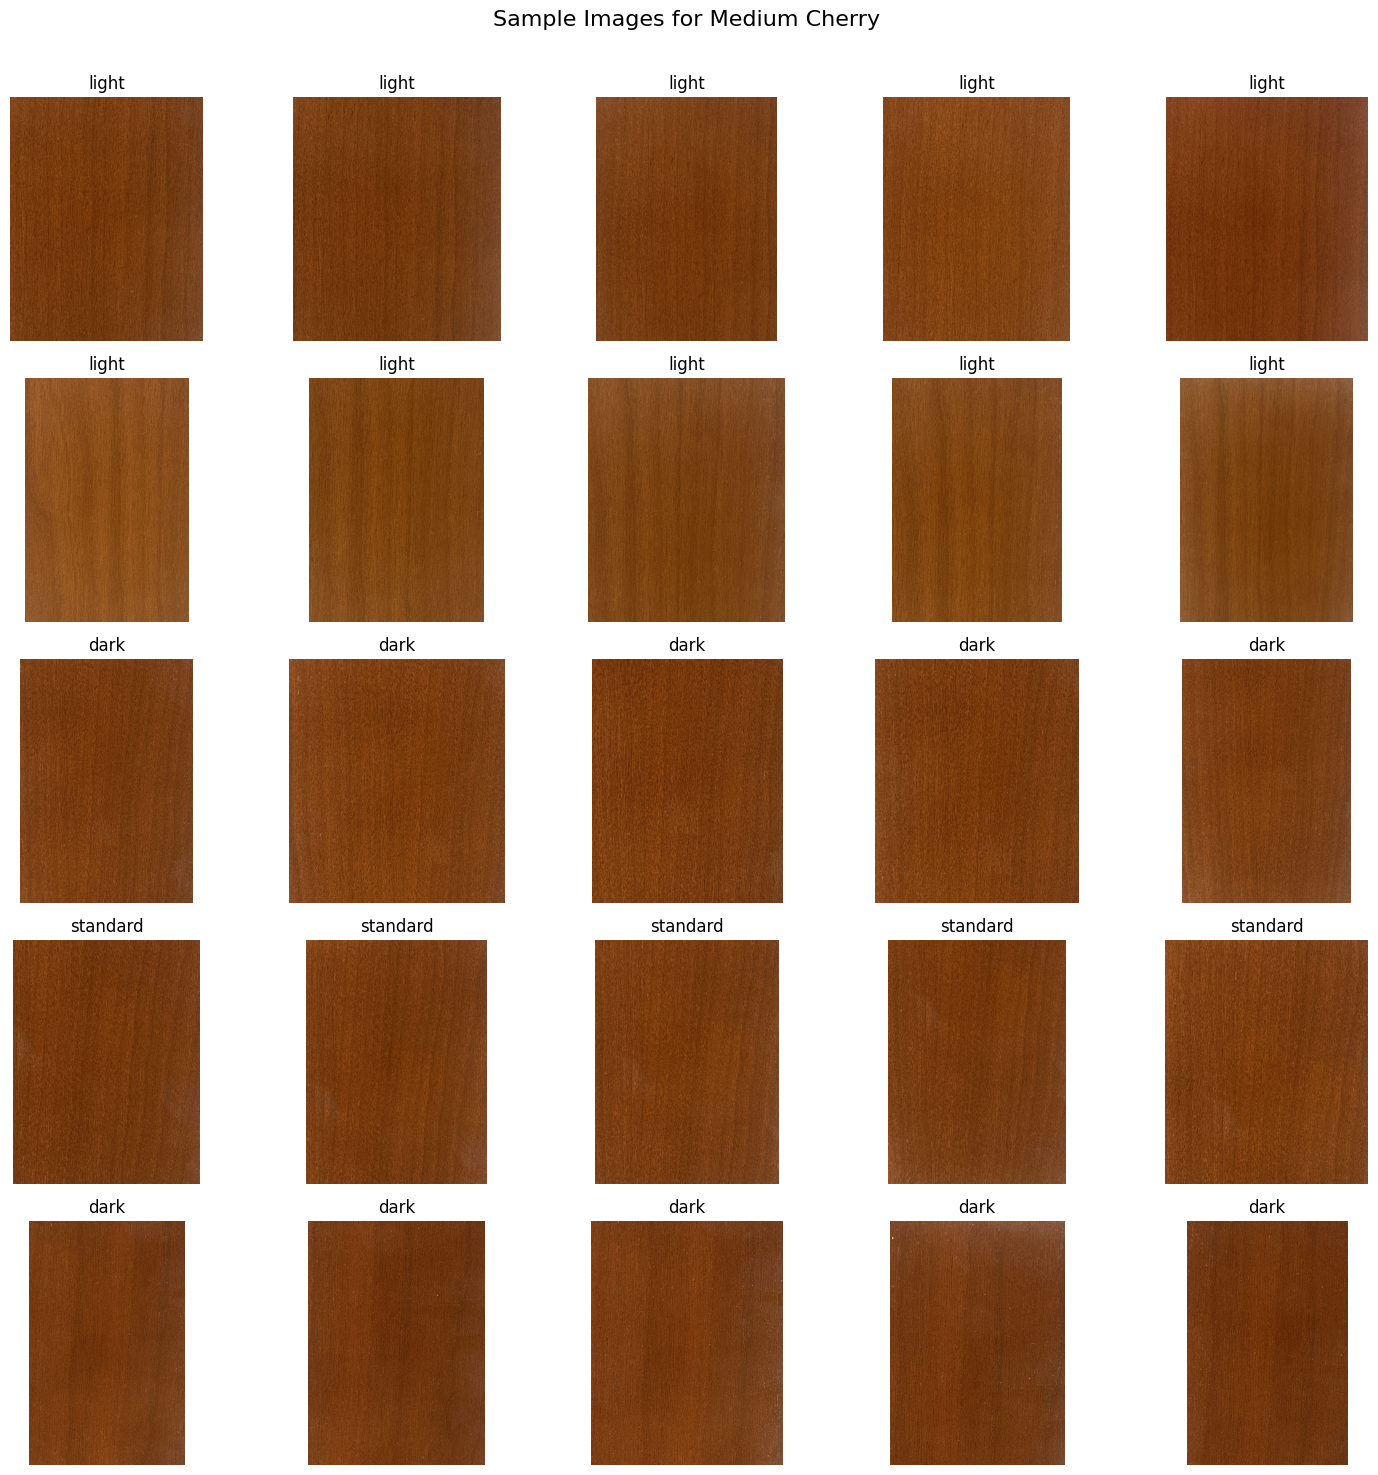

In [6]:
# Function to visualize sample images
def plot_sample_images(df, color, n_samples=5):
    """
    Plot sample images for each category of a specific color.
    """
    # Filter by color
    color_df = df[df['color'] == color]
    
    # Get unique categories
    categories = color_df['category'].unique()
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(categories), n_samples, figsize=(n_samples * 3, len(categories) * 3))
    
    # Iterate through categories
    for i, category in enumerate(categories):
        # Get paths for this category
        category_paths = color_df[color_df['category'] == category]['img_path'].values
        
        # Sample n_samples or fewer if not enough available
        sample_size = min(n_samples, len(category_paths))
        sample_paths = np.random.choice(category_paths, size=sample_size, replace=False)
        
        # Load and display each sample
        for j, path in enumerate(sample_paths):
            if j < n_samples:  # Ensure we don't exceed the number of subplots
                img = Image.open(path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{category.split('-')[-1]}")
                axes[i, j].axis('off')
                
    plt.suptitle(f"Sample Images for {color.replace('-', ' ').title()}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Visualize sample images for each color
for color in CONFIG['colors']:
    plot_sample_images(dataset_df, color)

## Image Preprocessing and Data Preparation

Now, let's create functions to preprocess the images and prepare the data for training.

In [7]:
def preprocess_image(img_path, target_size, color_space='RGB'):
    """
    Load and preprocess an image.
    """
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        return None  # or return a default image (e.g., a black image) if appropriate
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        return None  # or return a default image (e.g., a black image) if appropriate
    # Convert color space if needed
    if color_space == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LAB':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Resize
    img = cv2.resize(img, target_size)
    
    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    
    return img

def prepare_data_for_color(df, color, img_size, color_space, val_split, test_split):
    """
    Prepare data for a specific color.
    Returns X_train, y_train, X_val, y_val, X_test, y_test
    """
    # Filter data for this color
    color_df = df[df['color'] == color].copy()
    
    # Split into training, validation, and test sets
    train_val_df, test_df = train_test_split(color_df, test_size=test_split, stratify=color_df['in_range'], random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=val_split / (1 - test_split), stratify=train_val_df['in_range'], random_state=42)
    
    # Function to load and process images for a dataframe
    def process_dataframe(df):
        X = []
        y = []
        
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {color}"):
            # Load and preprocess image
            img = preprocess_image(row['img_path'], img_size, color_space)
            X.append(img)
            
            # Encode label (1 for in_range, 0 for out_of_range)
            y.append(1 if row['in_range'] else 0)
            
        return np.array(X), np.array(y)
    
    # Process each dataframe
    X_train, y_train = process_dataframe(train_df)
    X_val, y_val = process_dataframe(val_df)
    X_test, y_test = process_dataframe(test_df)
    
    # Print dataset statistics
    print(f"\n{color.title()} Dataset:")
    print(f"Training: {len(X_train)} images")
    print(f"Validation: {len(X_val)} images")
    print(f"Test: {len(X_test)} images")
    print(f"In-range ratio - Train: {y_train.mean():.2f}, Val: {y_val.mean():.2f}, Test: {y_test.mean():.2f}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

## Model Building

Now let's create the model architecture. We'll use a pre-trained model as a feature extractor and add custom classification layers on top.

In [8]:
def create_model(input_shape, model_type='EfficientNetB0'):
    """
    Create a model with a pre-trained base and custom classification head.
    """
    # Create base model
    if model_type == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_type == 'ResNet50V2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Create classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

In [9]:
def train_model_for_color(color, X_train, y_train, X_val, y_val):
    """
    Train a model for a specific color.
    """
    # Create data generators for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Create model
    input_shape = X_train[0].shape
    model = create_model(input_shape, CONFIG['model_type'])
    
    # Setup callbacks
    checkpoint = ModelCheckpoint(
        f"best_model_{color}.keras",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    callbacks = [checkpoint, early_stop, reduce_lr]
    
    # Train model
    print(f"\nTraining model for {color}...")
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=CONFIG['batch_size']),
        steps_per_epoch=len(X_train) // CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{color} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{color} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Load the best model
    best_model = load_model(f"best_model_{color}.keras")
    
    return best_model, history

In [10]:
def evaluate_model(model, X_test, y_test, color):
    """
    Evaluate the model on test data.
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Out of Range', 'In Range'])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\nEvaluation for {color}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Out of Range', 'In Range'],
                yticklabels=['Out of Range', 'In Range'])
    plt.title(f'Confusion Matrix for {color}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Plot some misclassified examples if there are any
    misclassified = np.where(y_pred != y_test)[0]
    if len(misclassified) > 0:
        num_examples = min(5, len(misclassified))
        sample_indices = np.random.choice(misclassified, num_examples, replace=False)
        
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(sample_indices):
            plt.subplot(1, num_examples, i+1)
            plt.imshow(X_test[idx])
            plt.title(f"True: {'In' if y_test[idx] == 1 else 'Out'}\nPred: {'In' if y_pred[idx] == 1 else 'Out'}\nProb: {y_pred_prob[idx][0]:.2f}")
            plt.axis('off')
        plt.suptitle(f"Misclassified Examples for {color}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    
    return accuracy, report, conf_matrix

In [11]:
def visualize_feature_importance(model, X_test, y_test, color, num_samples=3):
    """
    Visualize which parts of the image are important for classification using Grad-CAM.
    """
    try:
        # Create Grad-CAM model
        last_conv_layer = None
        
        # Find the last convolutional layer
        for layer in reversed(model.layers[0].layers):
            if 'conv' in layer.name:
                last_conv_layer = layer.name
                break
        
        if last_conv_layer is None:
            print("Could not find a convolutional layer for Grad-CAM visualization.")
            return
        
        # Get correctly classified samples from each class
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        correct_indices = np.where(y_pred == y_test)[0]
        in_range_correct = [i for i in correct_indices if y_test[i] == 1]
        out_range_correct = [i for i in correct_indices if y_test[i] == 0]
        
        # Sample indices from each class
        sample_in_range = np.random.choice(in_range_correct, min(num_samples, len(in_range_correct)), replace=False)
        sample_out_range = np.random.choice(out_range_correct, min(num_samples, len(out_range_correct)), replace=False)
        sample_indices = np.concatenate([sample_in_range, sample_out_range])
        
        # Create the Grad-CAM model
        grad_model = tf.keras.models.Model(
            inputs=model.layers[0].inputs,
            outputs=[
                model.layers[0].get_layer(last_conv_layer).output,
                model.layers[-1].output
            ]
        )
        
        # Visualization function
        def make_gradcam_heatmap(img_array, pred_index=None):
            # Expand dimensions for batch
            img_array = np.expand_dims(img_array, axis=0)
            
            # Compute gradient of the predicted class with respect to the output feature map
            with tf.GradientTape() as tape:
                conv_output, predictions = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(predictions[0])
                class_channel = predictions[:, pred_index]
            
            # Extract gradients
            grads = tape.gradient(class_channel, conv_output)
            
            # Get mean intensity of gradients over feature maps
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            
            # Weight feature maps with gradients
            conv_output = conv_output[0]
            heatmap = conv_output @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            
            # Normalize heatmap
            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            
            return heatmap.numpy()
        
        # Plot the Grad-CAM visualizations
        plt.figure(figsize=(15, 3 * len(sample_indices)))
        for i, idx in enumerate(sample_indices):
            # Get the image
            img = X_test[idx]
            
            # Generate heatmap
            heatmap = make_gradcam_heatmap(img, 0)  # 0 for out-of-range, 1 for in-range
            
            # Convert heatmap to RGB
            heatmap = np.uint8(255 * heatmap)
            cmap = plt.cm.jet
            cmap_heatmap = cmap(heatmap)
            cmap_heatmap = np.delete(cmap_heatmap, 3, 2)  # Remove alpha channel
            
            # Resize heatmap to match image size
            heatmap_resized = cv2.resize(cmap_heatmap, (img.shape[1], img.shape[0]))
            
            # Overlay heatmap on image
            superimposed = img * 0.6 + heatmap_resized * 0.4
            superimposed = superimposed / np.max(superimposed)
            
            # Plot
            plt.subplot(len(sample_indices), 3, i*3+1)
            plt.imshow(img)
            plt.title(f"{'In Range' if y_test[idx] == 1 else 'Out of Range'}")
            plt.axis('off')
            
            plt.subplot(len(sample_indices), 3, i*3+2)
            plt.imshow(heatmap_resized)
            plt.title('Grad-CAM Heatmap')
            plt.axis('off')
            
            plt.subplot(len(sample_indices), 3, i*3+3)
            plt.imshow(superimposed)
            plt.title('Superimposed')
            plt.axis('off')
        
        plt.suptitle(f"Grad-CAM Visualization for {color}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    except Exception as e:
        print(f"Error in Grad-CAM visualization: {e}")

In [12]:
def predict_new_image(model, img_path, color, color_space='RGB', target_size=(224, 224)):
    """
    Predict whether a new image is in range or out of range.
    """
    # Preprocess image
    '''
    img = preprocess_image(img_path, target_size, color_space)
    
    # Expand dimensions to create a batch
    img_batch = np.expand_dims(img, axis=0)
    
    # Get prediction
    prediction = model.predict(img_batch)[0][0]
    
    # Determine class
    in_range = prediction > 0.5
    '''
    # Display image and prediction
    '''
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"{color.replace('-', ' ').title()}: {'In Range' if in_range else 'Out of Range'}\nConfidence: {prediction:.2f}")
    plt.axis('off')
    plt.show()
    '''
    return True, True
    return in_range, prediction

## Training, Evaluation, and Visualization for Each Color

Now we'll train and evaluate a model for each of the three wood stain colors.

In [13]:
# Dictionary to store models and results
models = {}
results = {}

# Train and evaluate for each color
for color in CONFIG['colors']:
    print(f"\n{'='*50}")
    print(f"Processing {color}")
    print(f"{'='*50}")
    
    # Prepare data
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_for_color(
        dataset_df, color, CONFIG['img_size'], CONFIG['color_space'],
        CONFIG['val_split'], CONFIG['test_split']
    )
    
    # Train model
    model, history = train_model_for_color(color, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    accuracy, report, conf_matrix = evaluate_model(model, X_test, y_test, color)
    
    # Visualize feature importance
    visualize_feature_importance(model, X_test, y_test, color)
    
    # Store model and results
    models[color] = model
    results[color] = {
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'history': history.history
    }


Processing medium-cherry


Processing medium-cherry:   0%|          | 0/84 [00:00<?, ?it/s]

Processing medium-cherry:   0%|          | 0/24 [00:00<?, ?it/s]

Processing medium-cherry:   0%|          | 0/13 [00:00<?, ?it/s]


Medium-Cherry Dataset:
Training: 84 images
Validation: 24 images
Test: 13 images
In-range ratio - Train: 0.64, Val: 0.67, Test: 0.62
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB




Training model for medium-cherry...
Epoch 1/20


2025-04-20 22:06:35.211003: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - ETA: 0s - loss: 0.7682 - accuracy: 0.3846 - precision: 0.6250 - recall: 0.1471 
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_model_medium-cherry.keras


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

## Model Deployment and Usage

Now let's create a function to predict whether a new image is in range or out of range for a specific color.

In [ ]:
def predict_stain_quality(img_path, color=None):
    """
    Predict whether a wood stain image is in range or out of range.
    If color is None, predict for all three colors.
    """
    if color is not None and color not in CONFIG['colors']:
        print(f"Error: Color {color} not recognized. Valid colors are: {CONFIG['colors']}")
        return
    
    colors_to_predict = [color] if color is not None else CONFIG['colors']
    
    results = {}
    for c in colors_to_predict:
        is_in_range, confidence = predict_new_image(
            models[c], img_path, c, CONFIG['color_space'], CONFIG['img_size']
        )
        results[c] = {
            'is_in_range': bool(is_in_range),
            'confidence': float(confidence),
            'prediction': 'In Range' if is_in_range else 'Out of Range'
        }
    
    # Print results in a table
    if len(colors_to_predict) > 1:
        result_df = pd.DataFrame([
            {
                'Color': c.replace('-', ' ').title(),
                'Prediction': results[c]['prediction'],
                'Confidence': f"{results[c]['confidence']:.2f}"
            }
            for c in colors_to_predict
        ])
        
        print("\nPrediction Results:")
        print(result_df)
    
    return results

In [ ]:
# Example usage
# Replace with a path to a new image
sample_image_path = "path/to/new/image.jpg"

# predict_stain_quality(sample_image_path)  # For all colors
# predict_stain_quality(sample_image_path, "medium-cherry")  # For a specific color

## Save Models for Later Use

Finally, let's save our trained models for future use.

In [ ]:
# Save models
for color, model in models.items():
    model_path = f"{color}_classifier_model.keras"
    model.save(model_path)
    print(f"Model for {color} saved to {model_path}")

# Save configuration
import json
with open("model_config.json", "w") as f:
    json.dump(CONFIG, f)
print("Configuration saved to model_config.json")

In [ ]:
# Function to load models
def load_saved_models():
    loaded_models = {}
    
    # Load configuration
    with open("model_config.json", "r") as f:
        config = json.load(f)
    
    # Load models
    for color in config['colors']:
        model_path = f"{color}_classifier_model.keras"
        if os.path.exists(model_path):
            loaded_models[color] = load_model(model_path)
            print(f"Model for {color} loaded successfully")
        else:
            print(f"Model for {color} not found at {model_path}")
    
    return loaded_models, config

## Conclusion

In this notebook, we've built and evaluated three binary classification models, one for each wood stain color (medium cherry, desert oak, and graphite walnut). Each model can determine if a new image of that color is "in range" or "out of range".

### Key Steps:
1. **Data Exploration**: We analyzed the distribution of images across categories and visualized sample images from each color and category.
2. **Preprocessing**: We applied resizing, normalization, and optional color space transformations.
3. **Model Architecture**: We used a pre-trained CNN (EfficientNetB0 or ResNet50V2) as a feature extractor, with custom classification layers on top.
4. **Training Strategy**: We applied data augmentation, early stopping, and learning rate reduction to enhance model performance.
5. **Evaluation**: We assessed model performance using accuracy, precision, recall, and F1-score metrics.
6. **Visualization**: We used Grad-CAM to visualize which parts of the image the model focuses on for classification.
7. **Deployment**: We created a function to easily predict whether new images are in range or out of range.

### Potential Improvements:
1. **Hyperparameter Tuning**: Fine-tune learning rates, batch sizes, and model architectures.
2. **Fine-Tuning**: Unfreeze more layers of the pre-trained model during training.
3. **Ensemble Methods**: Combine predictions from multiple models for better performance.
4. **Advanced Augmentation**: Use more sophisticated augmentation techniques specific to wood stain images.
5. **Color Features**: Extract and engineer specific color features important for wood stain classification.

This notebook provides a comprehensive solution for wood stain quality control through image classification.